In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

import sys

from scipy.stats import norm, multivariate_normal, beta, binom, stats
from scipy.stats import t as stats_t
from scipy.special import beta as beta_func
from scipy.special import binom as special_binom
from scipy.special import betaln as special_betaln
from scipy.optimize import fmin
from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
def HDIofICDF(dist_name, credMass=0.95, **args):
    # freeze distribution with given arguments
    distri = dist_name(**args)
    # initial guess for HDIlowTailPr
    incredMass =  1.0 - credMass

    def intervalWidth(lowTailPr):
        return distri.ppf(credMass + lowTailPr) - distri.ppf(lowTailPr)

    # find lowTailPr that minimizes intervalWidth
    HDIlowTailPr = fmin(intervalWidth, incredMass, ftol=1e-8, disp=False)[0]
    # return interval as array([low, high])
    return distri.ppf([HDIlowTailPr, credMass + HDIlowTailPr])

In [4]:
def bern_beta(prior_shape, data_vec, cred_mass=0.95):

    # Check for errors in input arguments:
    if len(prior_shape) != 2:
        sys.exit('prior_shape must have two components.')
    if any([i < 0 for i in prior_shape]):
        sys.exit('prior_shape components must be positive.')
    if any([i != 0 and i != 1 for i in data_vec]):
        sys.exit('data_vec must be a vector of 1s and 0s.')
    if cred_mass <= 0 or cred_mass >= 1.0:
        sys.exit('cred_mass must be between 0 and 1.')

    # Rename the prior shape parameters, for convenience:
    a = prior_shape[0]
    b = prior_shape[1]
    # Create summary values of the data:
    z = sum(data_vec[data_vec == 1])  # number of 1's in data_vec
    N = len(data_vec)   # number of flips in data_vec
    # Compute the posterior shape parameters:
    post_shape = [a+z, b+N-z]
    # Compute the evidence, p(D):
    p_data = beta_func(z+a, N-z+b)/beta_func(a, b)
    # Construct grid of theta values, used for graphing.
    bin_width = 0.005  # Arbitrary small value for comb on theta.
    theta = np.arange(bin_width/2, 1-(bin_width/2)+bin_width, bin_width)
    # Compute the prior at each value of theta.
    p_theta = beta.pdf(theta, a, b)
    # Compute the likelihood of the data at each value of theta.
    p_data_given_theta = theta**z * (1-theta)**(N-z)
    # Compute the posterior at each value of theta.
    post_a = a + z
    post_b = b+N-z
    p_theta_given_data = beta.pdf(theta, a+z, b+N-z)
    # Determine the limits of the highest density interval
    intervals = HDIofICDF(beta, cred_mass, a=post_shape[0], b=post_shape[1])

    # Plot the results.
    plt.figure(figsize=(12, 12))
    plt.subplots_adjust(hspace=0.7)

    # Plot the prior.
    locx = 0.05
    plt.subplot(3, 1, 1)
    plt.plot(theta, p_theta)
    plt.xlim(0, 1)
    plt.ylim(0, np.max(p_theta)*1.2)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(\theta)$')
    plt.title('Prior')
    plt.text(locx, np.max(p_theta)/2, r'beta($\theta$;%s,%s)' % (a, b))
    # Plot the likelihood:
    plt.subplot(3, 1, 2)
    plt.plot(theta, p_data_given_theta)
    plt.xlim(0, 1)
    plt.ylim(0, np.max(p_data_given_theta)*1.2)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(D|\theta)$')
    plt.title('Likelihood')
    plt.text(locx, np.max(p_data_given_theta)/2, 'Data: z=%s, N=%s' % (z, N))
    # Plot the posterior:
    plt.subplot(3, 1, 3)
    plt.plot(theta, p_theta_given_data)
    plt.xlim(0, 1)
    plt.ylim(0, np.max(p_theta_given_data)*1.2)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(\theta|D)$')
    plt.title('Posterior')
    locy = np.linspace(0, np.max(p_theta_given_data), 5)
    plt.text(locx, locy[1], r'beta($\theta$;%s,%s)' % (post_a, post_b))
    plt.text(locx, locy[2], 'P(D) = %g' % p_data)
    # Plot the HDI
    plt.text(locx, locy[3],
             'Intervals = %.3f - %.3f' % (intervals[0], intervals[1]))
    plt.fill_between(theta, 0, p_theta_given_data,
                    where=np.logical_and(theta > intervals[0],
                    theta < intervals[1]),
                        color='blue', alpha=0.3)
    return intervals

Everything above is imports

# Problem 6.1

A)

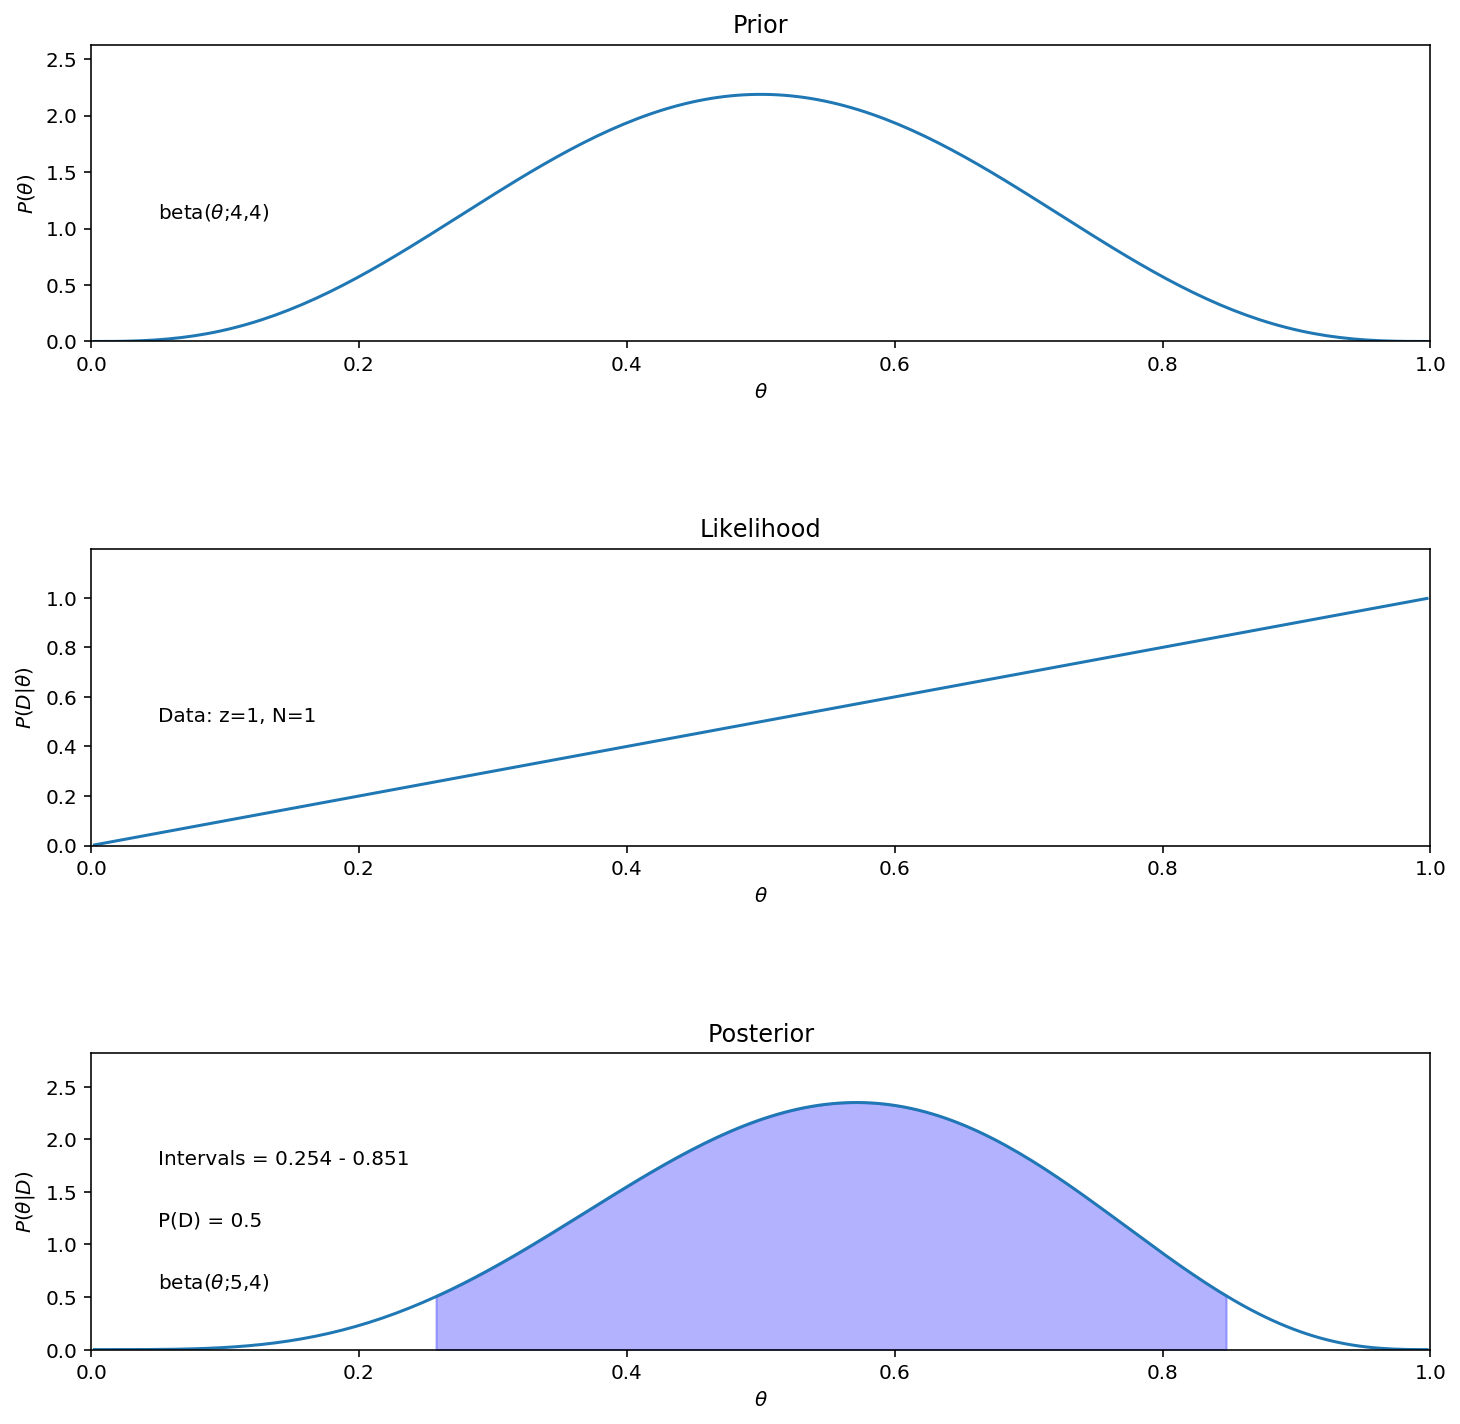

In [5]:
data_vec = np.repeat([1, 0], [1,0])
intervals = bern_beta(prior_shape=[4,4], data_vec=data_vec)
plt.show()

B)

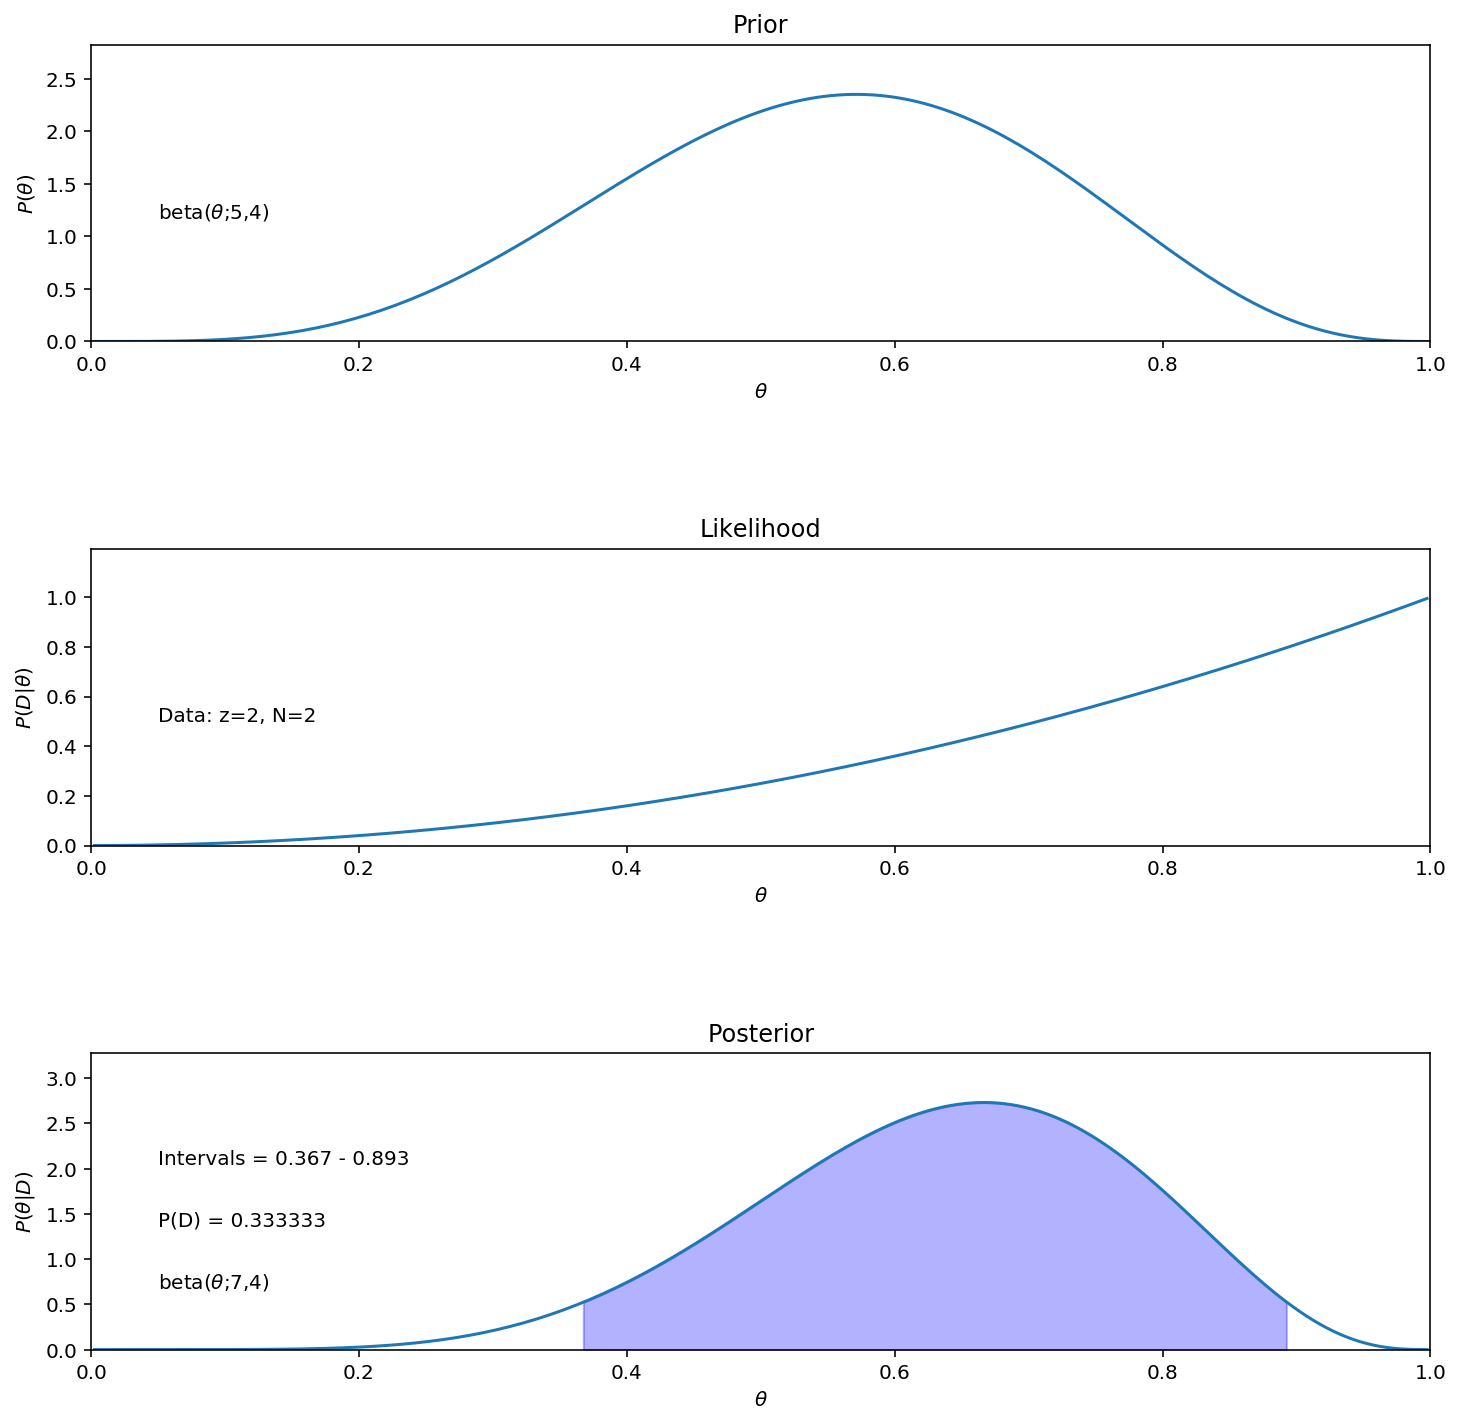

In [6]:
data_vec = np.repeat([1, 0], [2,0])
intervals = bern_beta(prior_shape=[5, 4], data_vec=data_vec)
plt.show()

C)

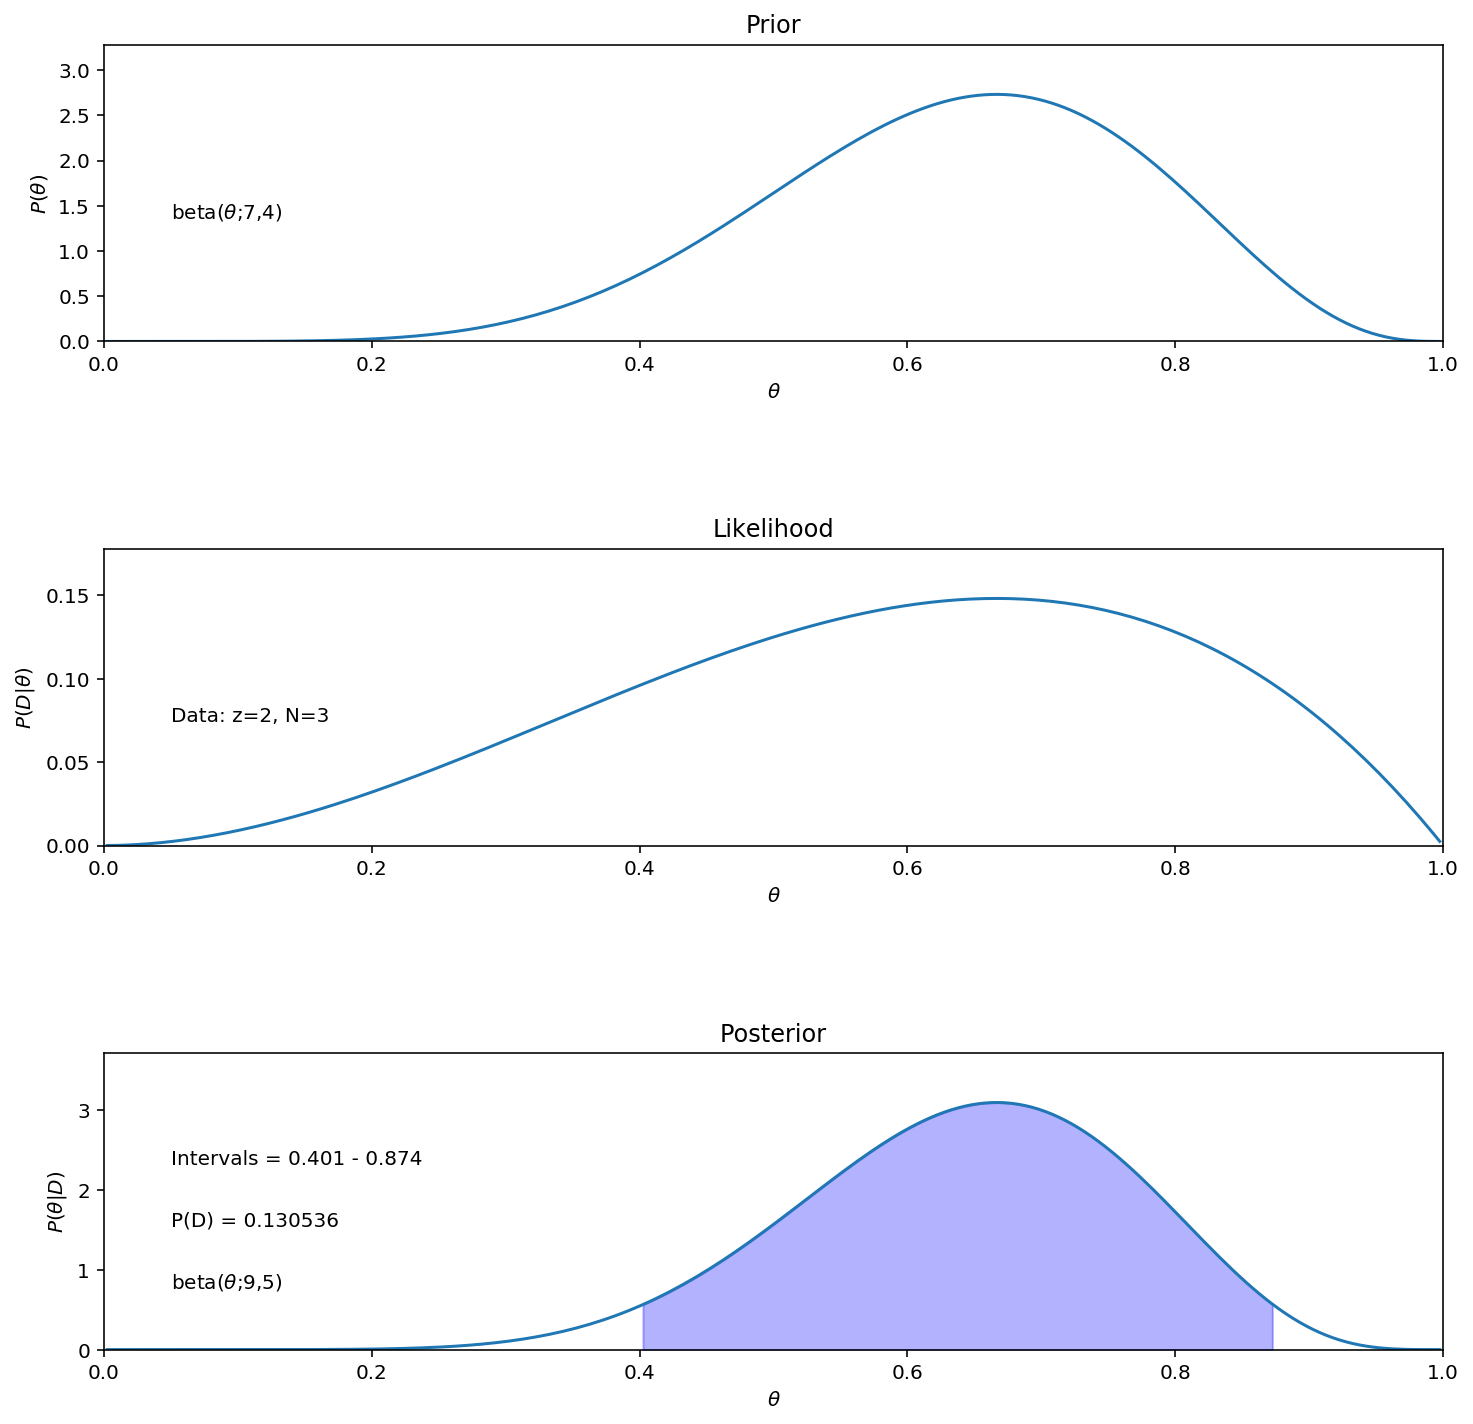

In [7]:
data_vec = np.repeat([1, 0], [2,1])
intervals = bern_beta(prior_shape=[7,4], data_vec=data_vec)
plt.show()

D)

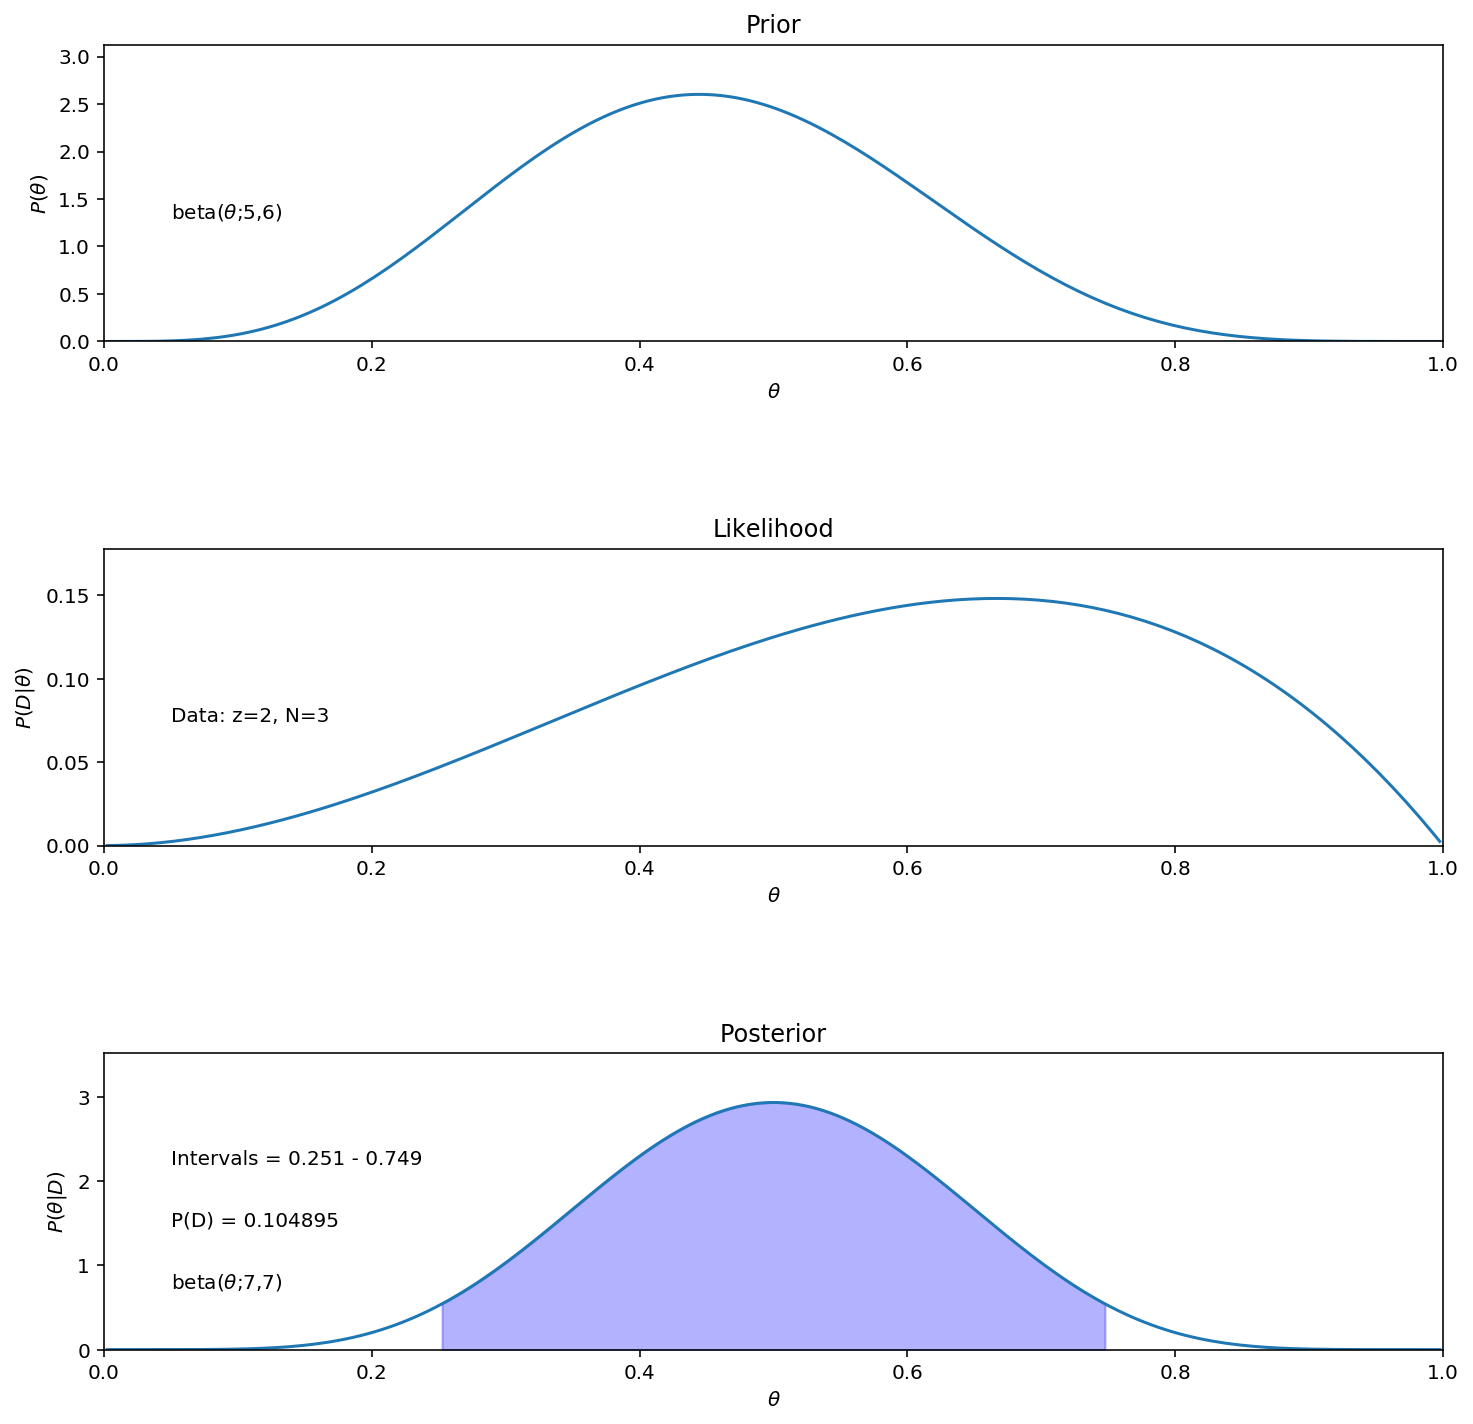

In [8]:
data_vec = np.repeat([1, 0], [2,1])
intervals = bern_beta(prior_shape=[5,6], data_vec=data_vec)
plt.show()

# Problem 6.2

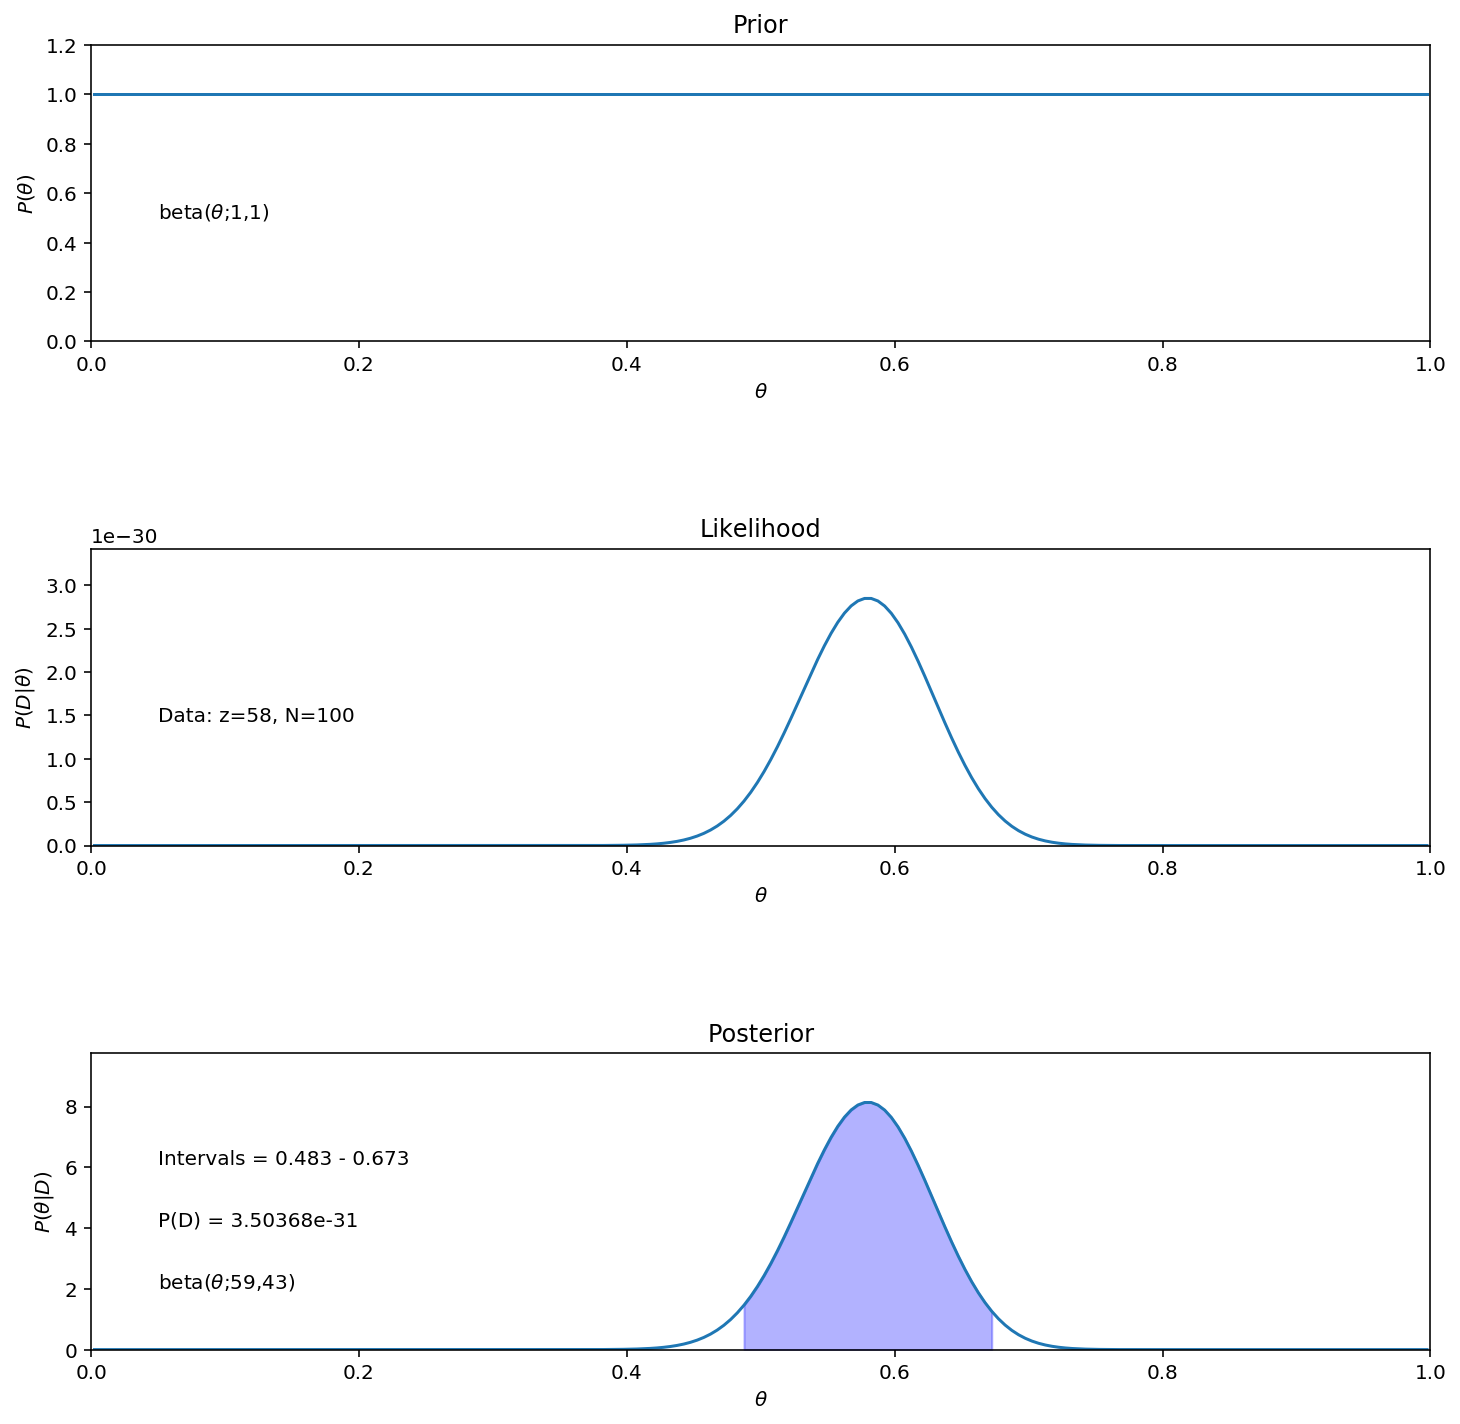

In [9]:
data_vec = np.repeat([1, 0], [58,100-58])  # 11 heads, 3 tail
intervals = bern_beta(prior_shape=[1,1], data_vec=data_vec)
plt.show()

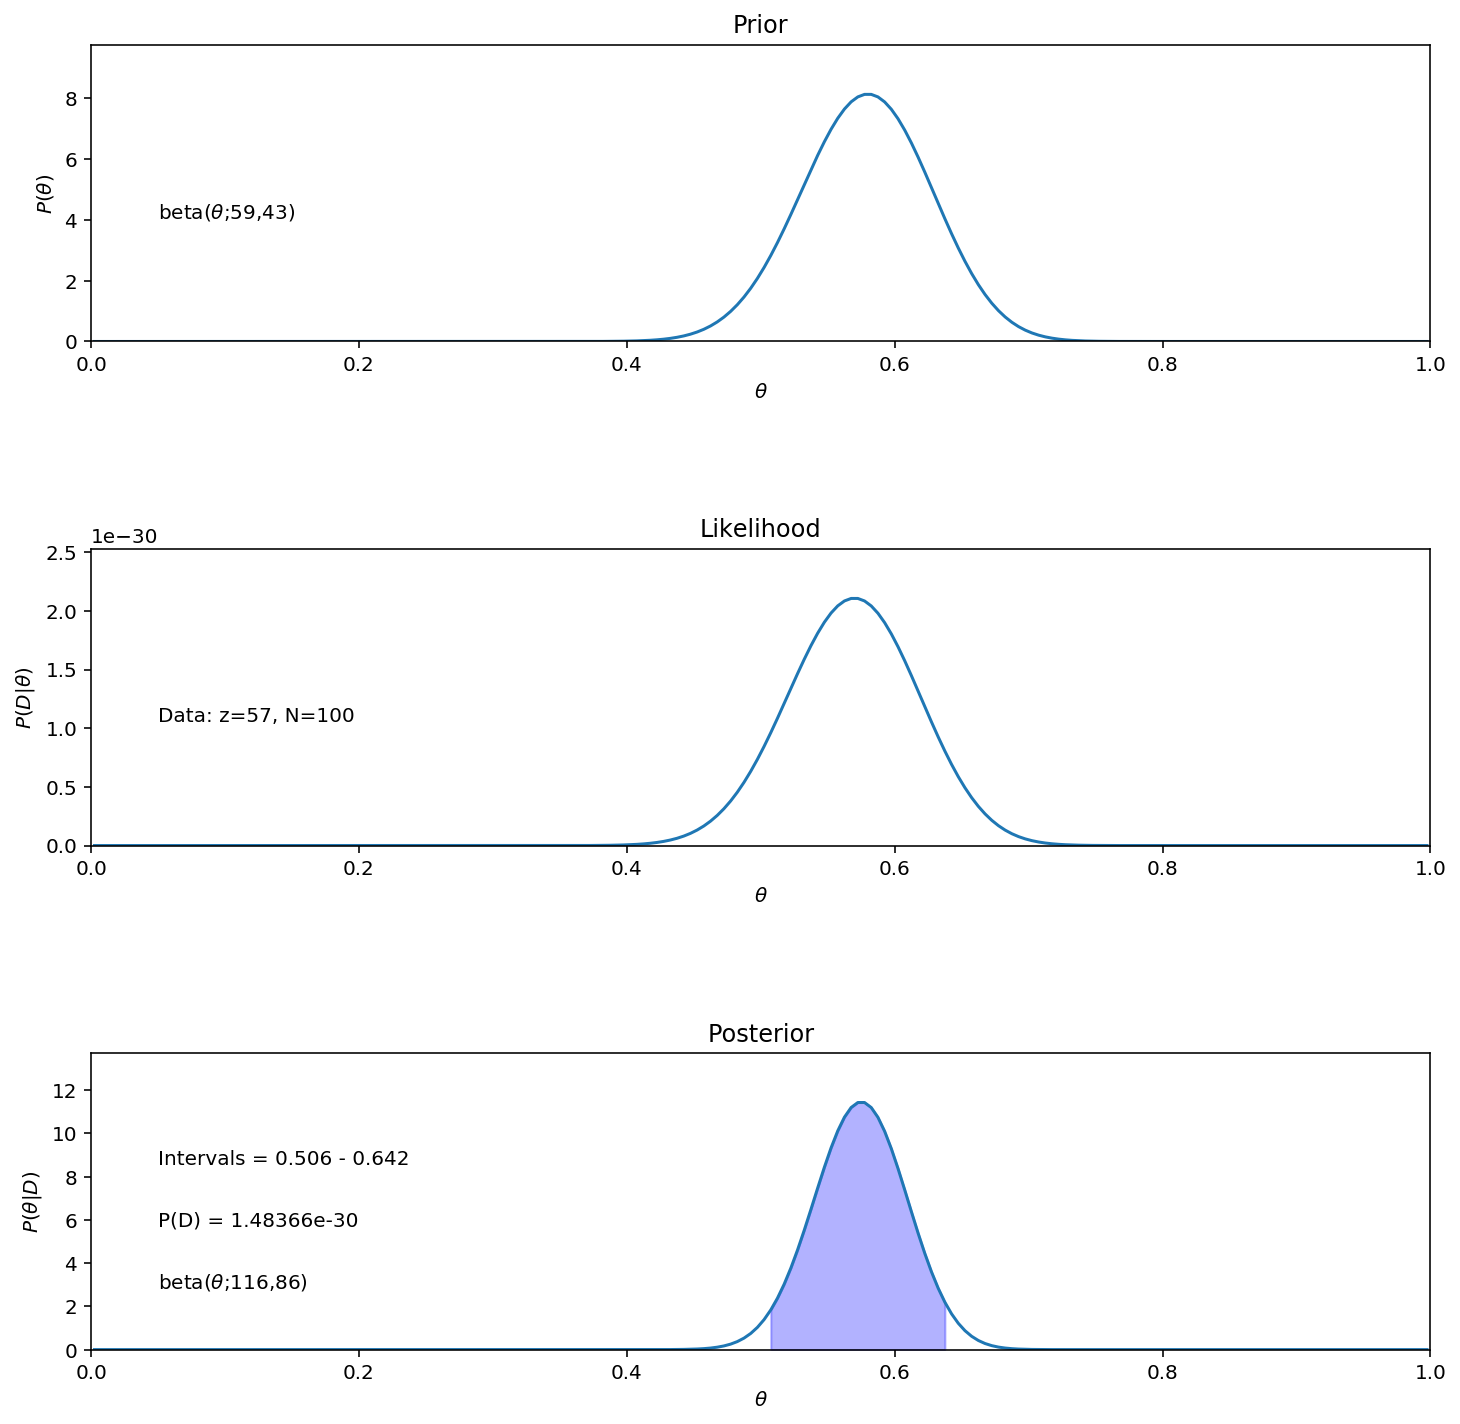

In [10]:
#The previous prior is used because we're taking more of the same data
data_vec = np.repeat([1, 0], [57,100-57])  # 11 heads, 3 tail
intervals = bern_beta(prior_shape=[59,43], data_vec=data_vec)
plt.show()

The posterior here is much narower that the posterior of the previous data set. This is what should happen because we have more data and can inform our prior much better from the previous data.

# Problem 6.3

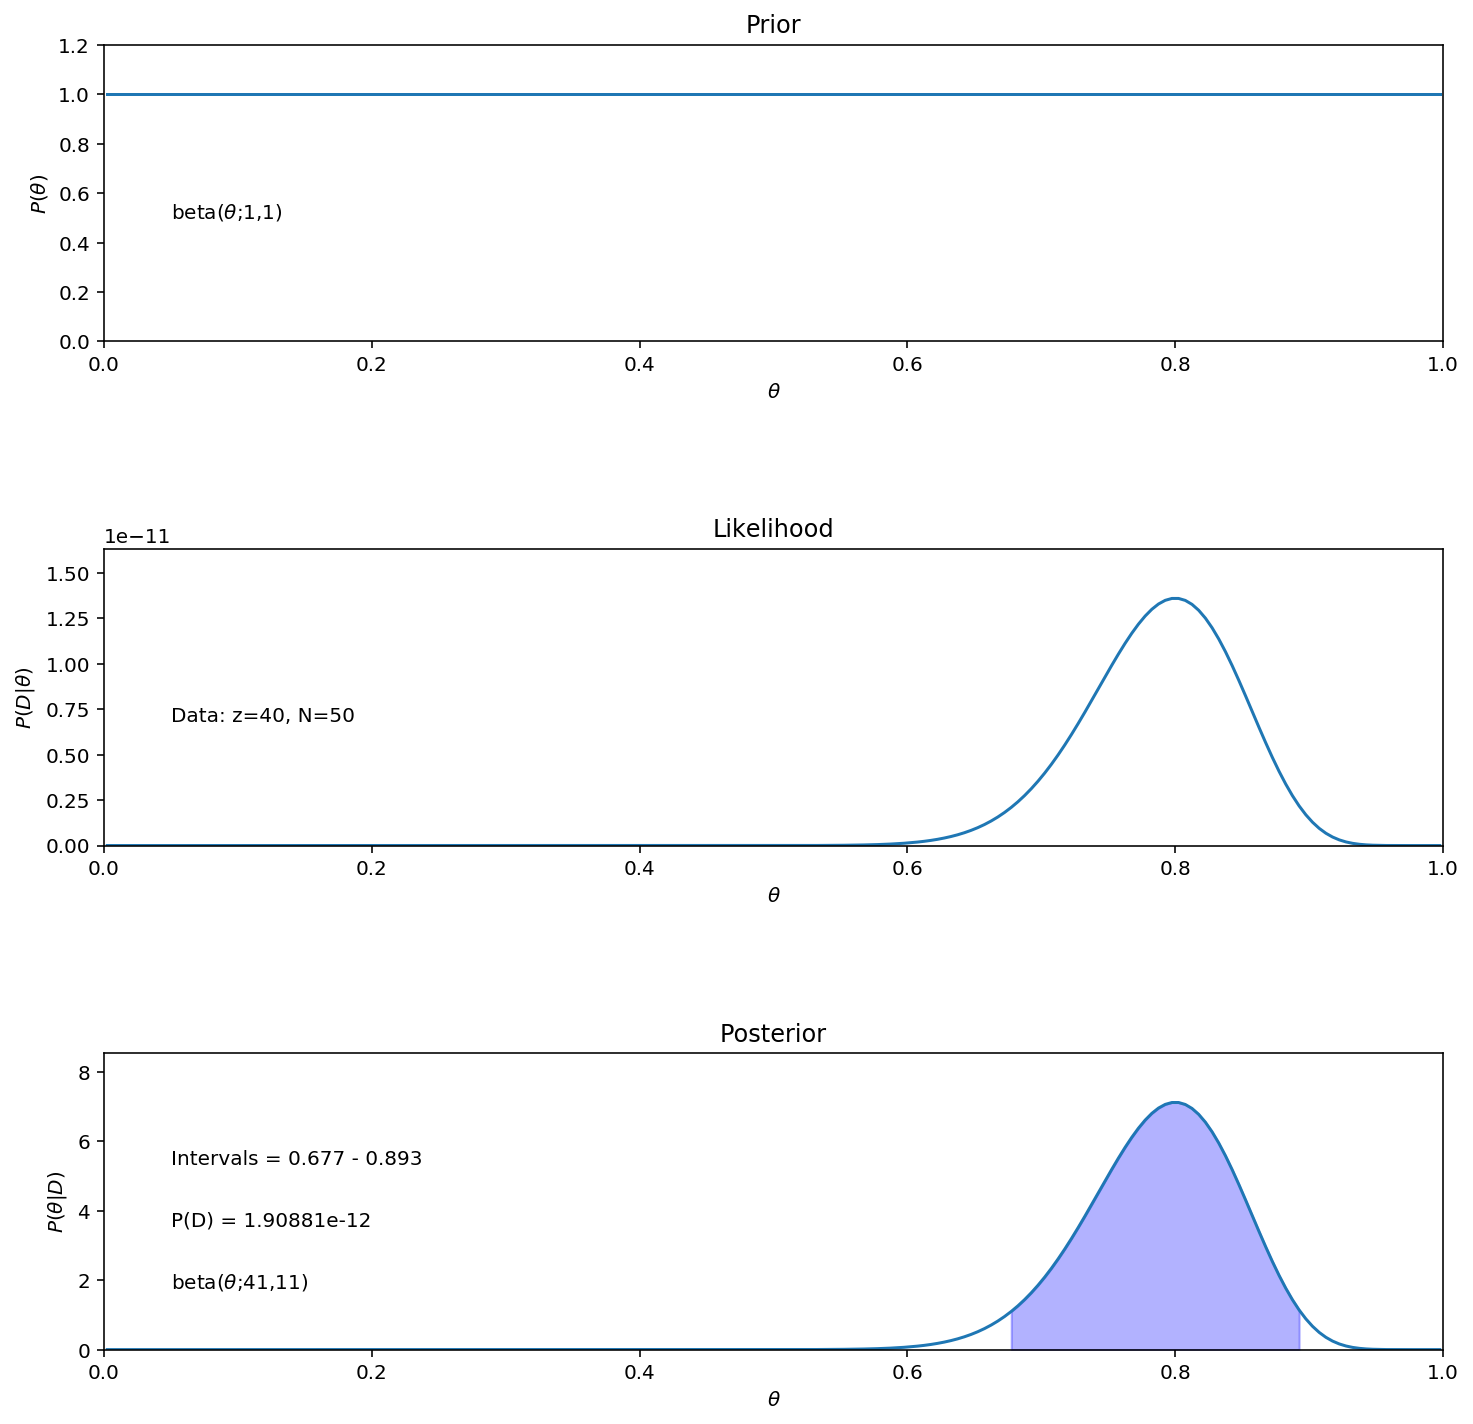

In [11]:
data_vec = np.repeat([1, 0], [40,10])  # 11 heads, 3 tail
intervals = bern_beta(prior_shape=[1,1], data_vec=data_vec)
plt.show()

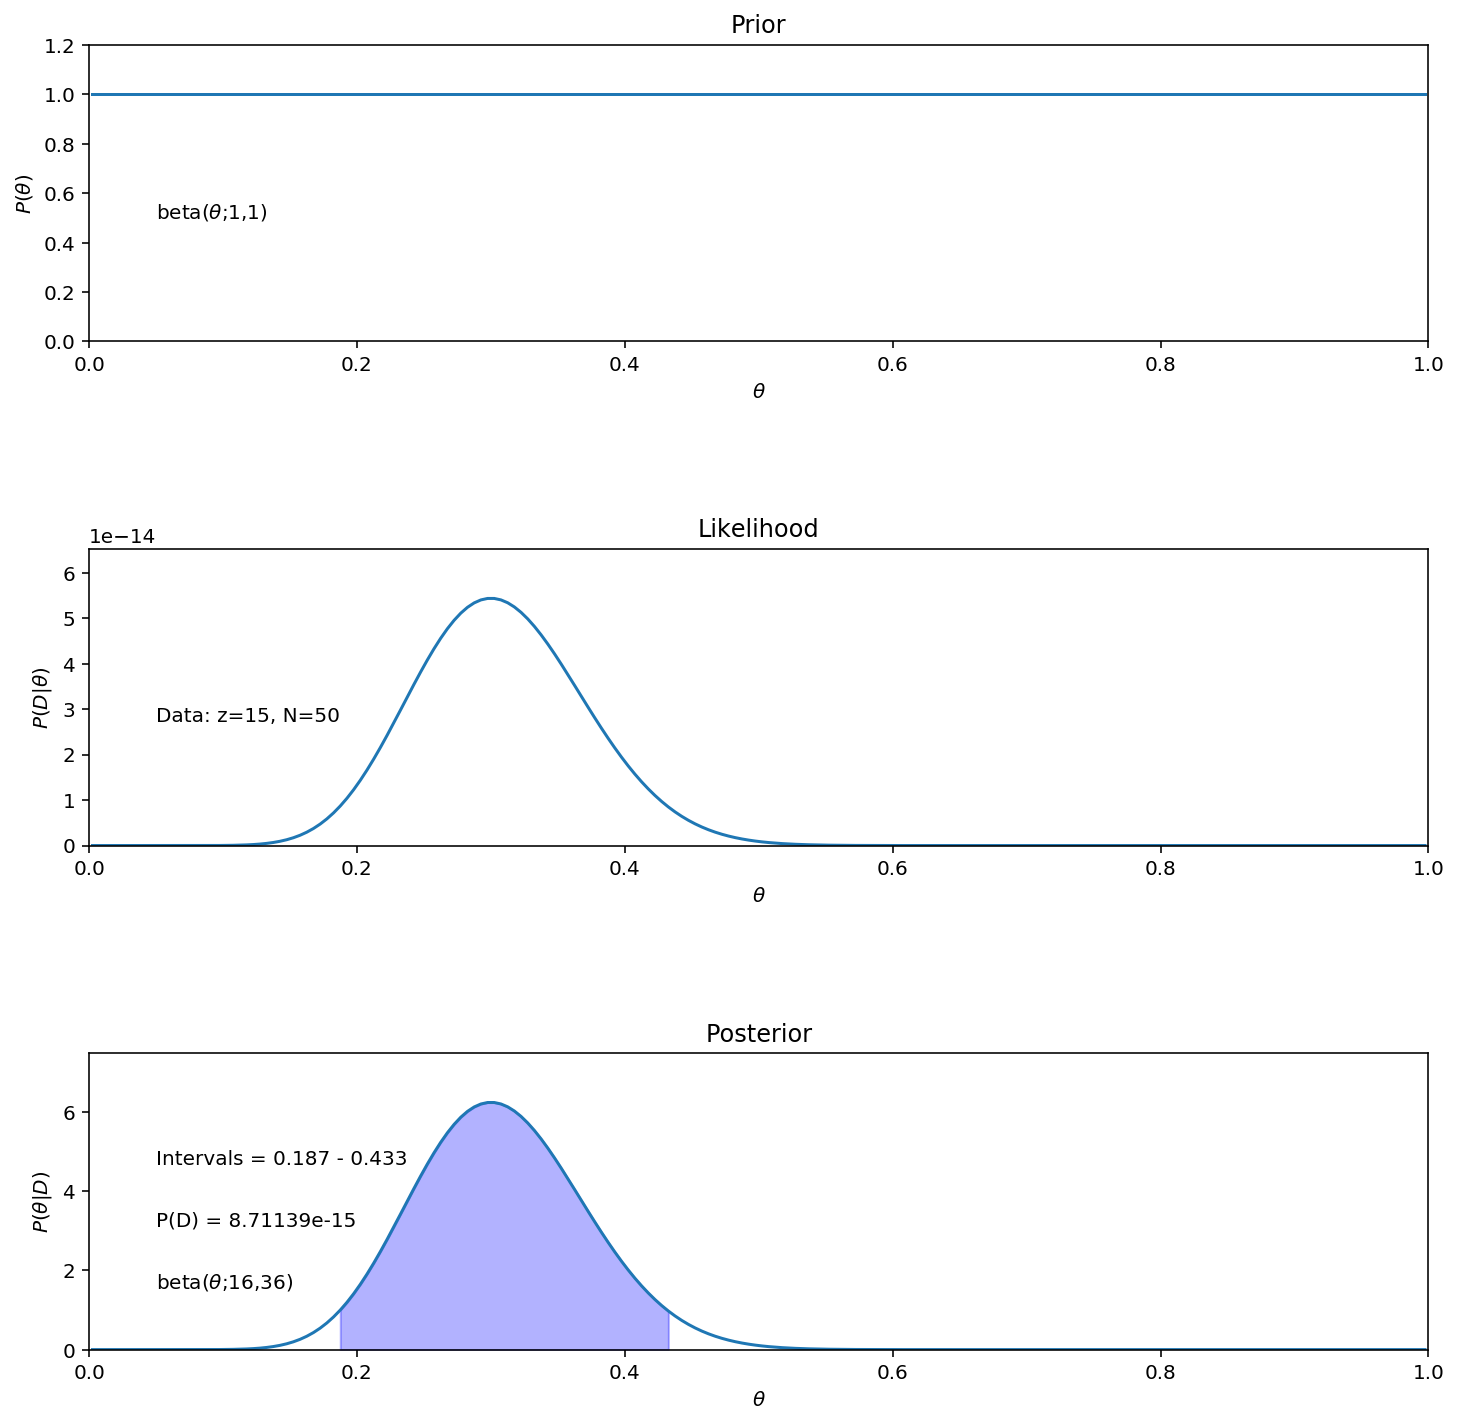

In [12]:
data_vec = np.repeat([1, 0], [15,35])  # 11 heads, 3 tail
intervals = bern_beta(prior_shape=[1,1], data_vec=data_vec)
plt.show()

I'd say the the two tests pretty conclusively show that both F and J ar biased to a specific word. With the flat prior and the data we can see that both peaks are very skewed away from .5, where F or J is just as likely as the other letter, to an amount that puts the likelyhood of .5 at almost zero, if not that.

# Problem 6.4

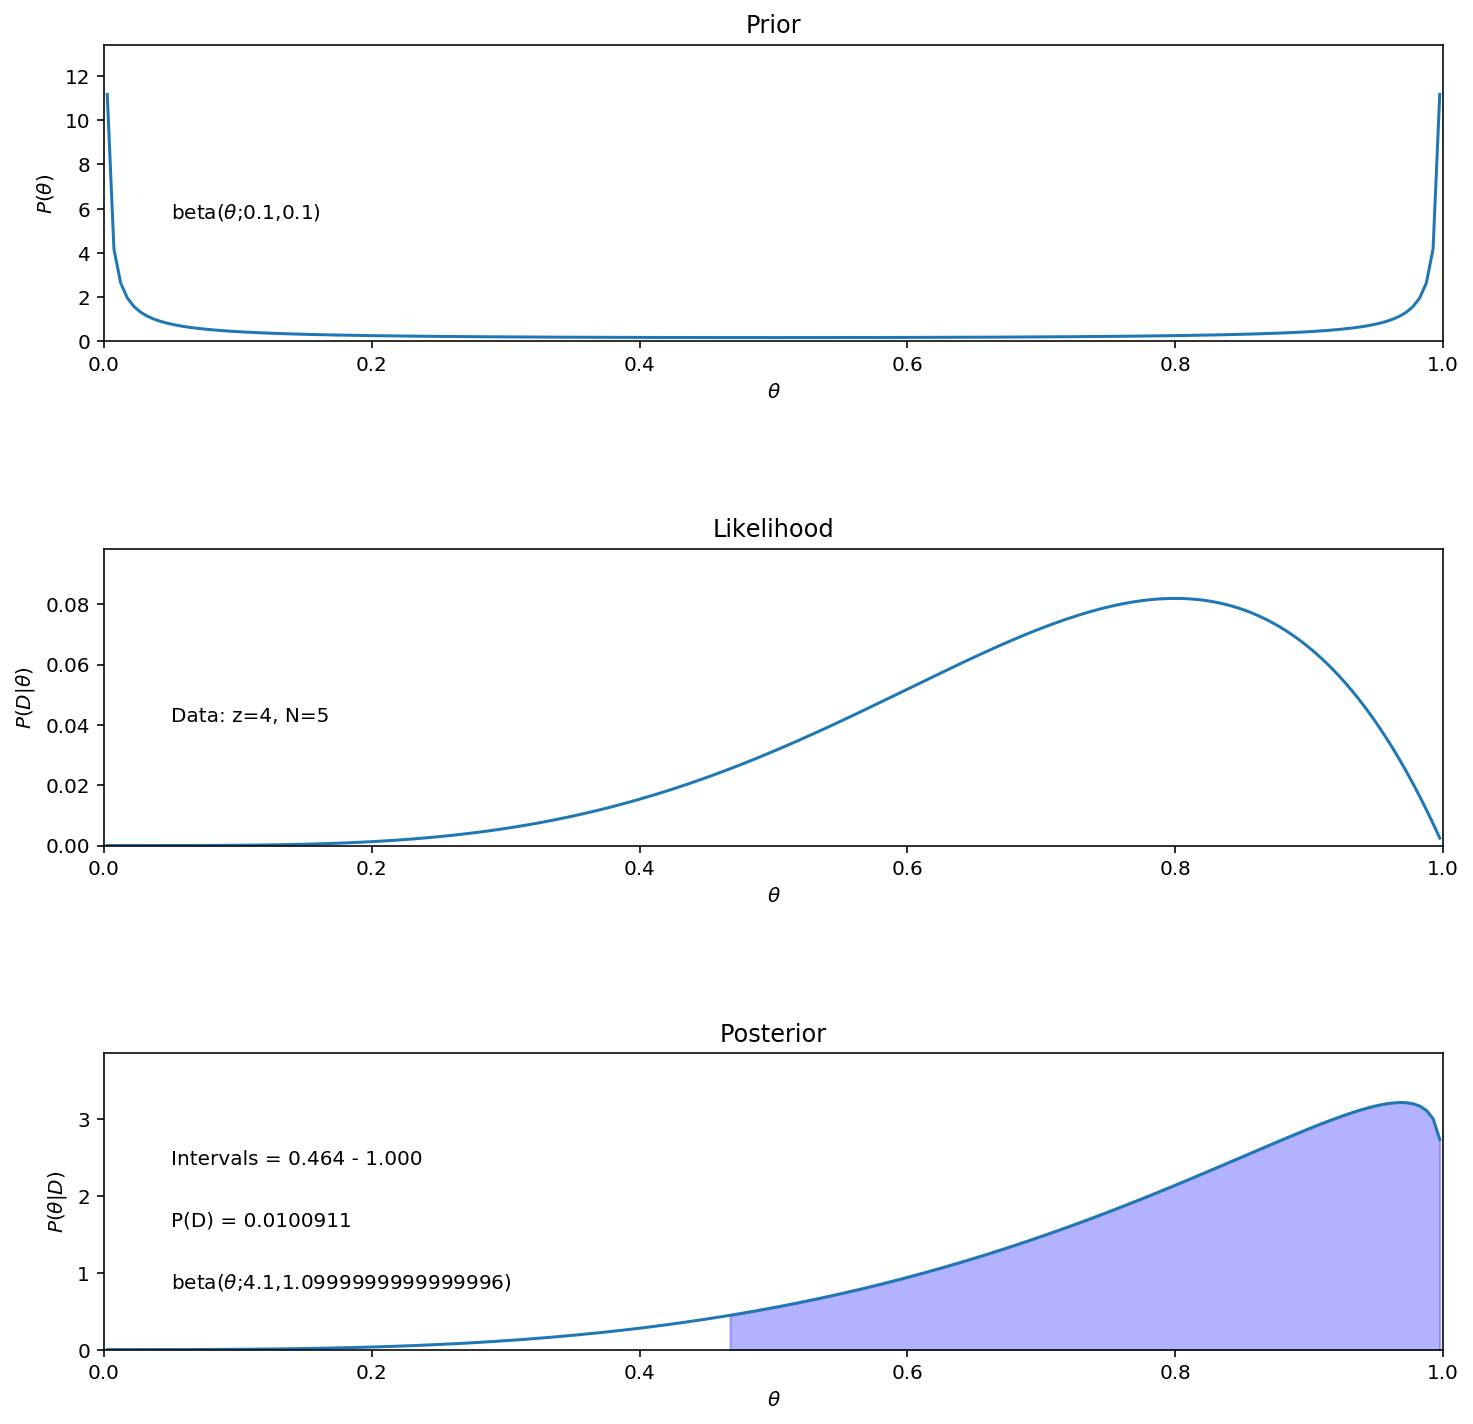

In [13]:
data_vec = np.repeat([1, 0], [4,1])  # 11 heads, 3 tail
intervals = bern_beta(prior_shape=[.1,.1], data_vec=data_vec)
plt.show()

You can clearly see the probability that the next coin flip will be heads is extrememly high but we don't know for certain because the 95% HDI contains 0.5 so it it still possible that this coin is fair, but it's most likely not

# Problem 6.5

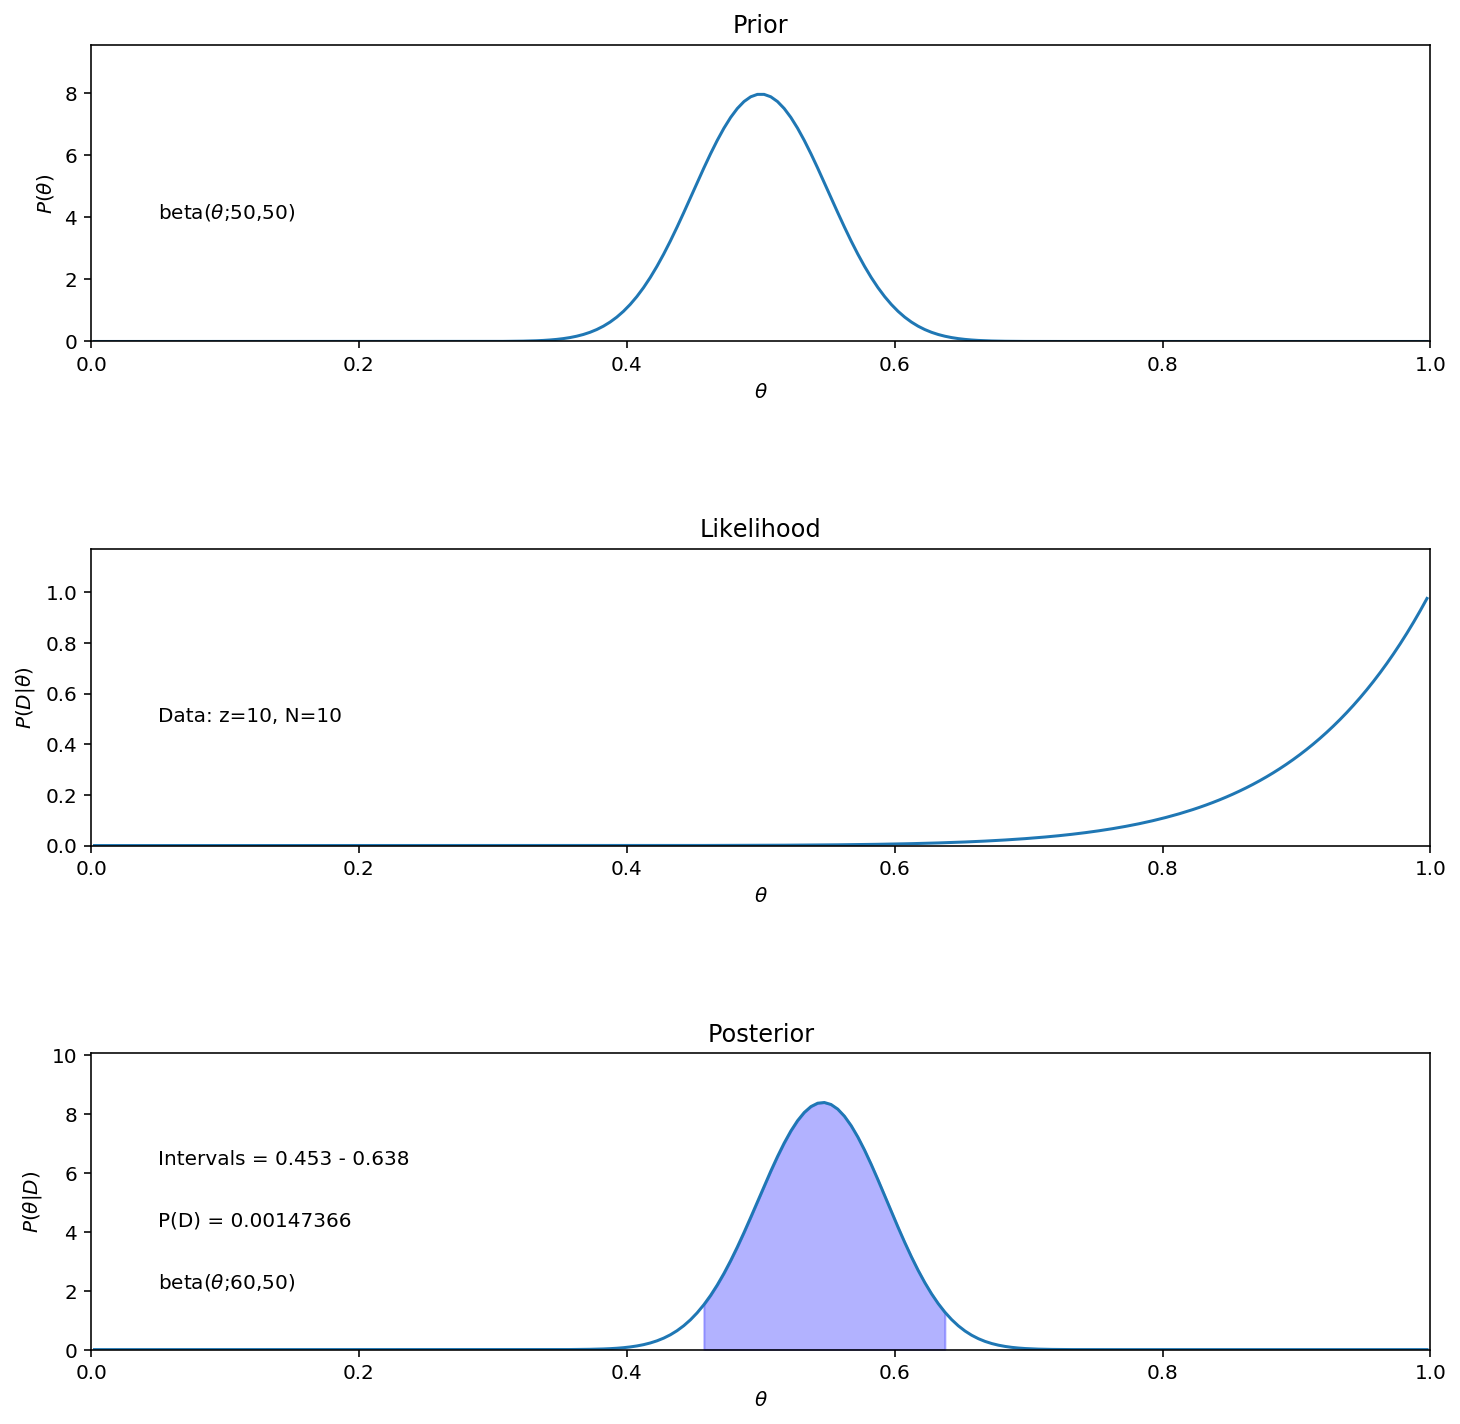

In [14]:
data_vec = np.repeat([1, 0], [10,0])  # 11 heads, 3 tail
intervals = bern_beta(prior_shape=[50, 50], data_vec=data_vec)
plt.show()

Because of the strong prior, the posterior doesn't move much even though the data is heavily skewed. 50, 50 was chosen because we wanted the data to have about a 10% "say" in the posterior because we really think its fair. If it wasn't then we'd need to take more data

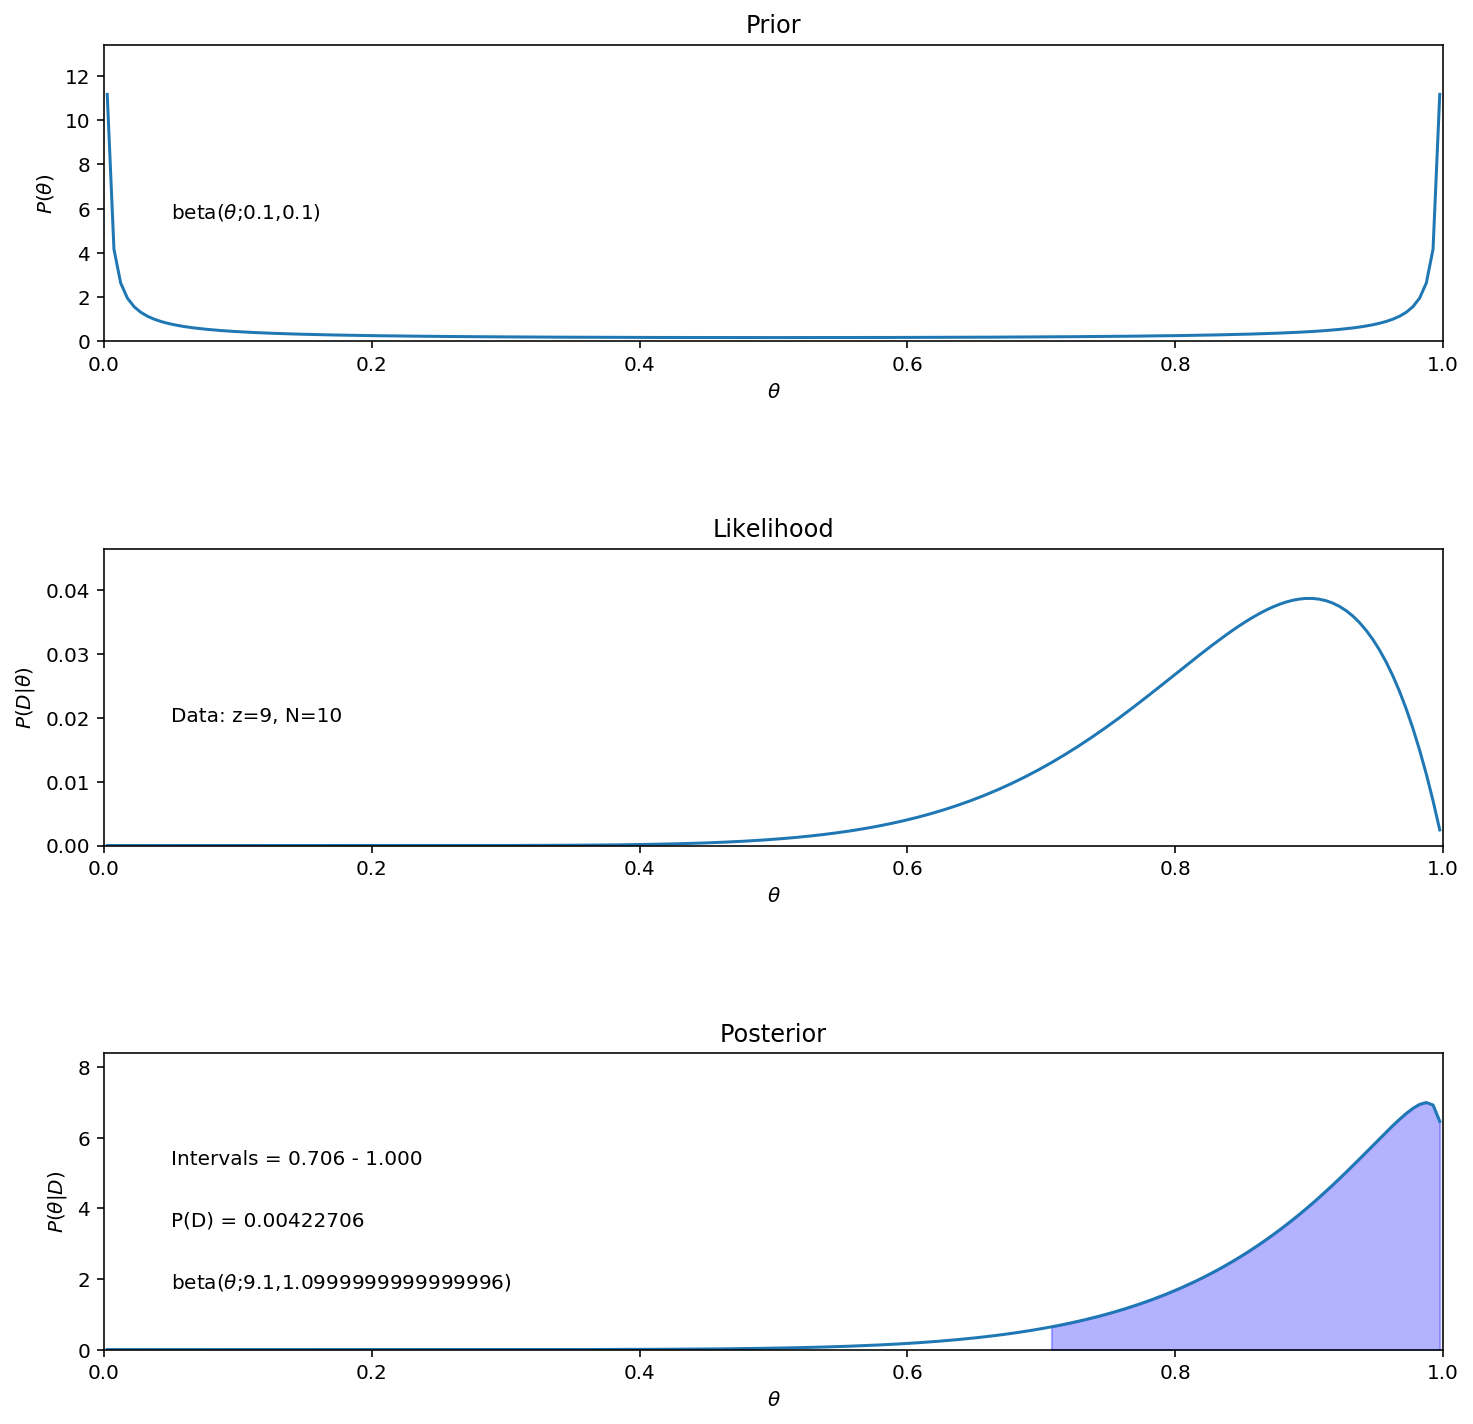

In [15]:
data_vec = np.repeat([1, 0], [9,1])  # 11 heads, 3 tail
intervals = bern_beta(prior_shape=[.1, .1], data_vec=data_vec)
plt.show()

Basically the same as 6.5 but this time the coin is definitely a skewed coin because of our prior knowledge that it's a biased coin